# Demo for Effective Dimension Class

In [1]:
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit.utils import QuantumInstance
from qiskit import Aer, QuantumCircuit

In [3]:
from qiskit_machine_learning.algorithms.effective_dimension import EffectiveDimension, LocalEffectiveDimension

In [4]:
# declare quantum instance
qi_sv = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

## A. Use with Circuit QNN

### 1. Create QNN

In [29]:
# number of times to repeat the variational circuit
blocks = 1

# number of qubits, data samples and parameter sets to estimate the effective dimension
num_qubits = 3
num_inputs = 10
num_thetas = 10

# create ranges for the number of data, n
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

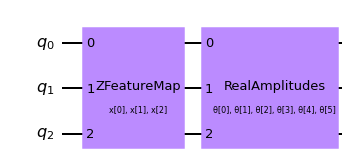

In [30]:
# create a feature map
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)

# create a variational circuit
ansatz = RealAmplitudes(num_qubits, reps=blocks)

# create quantum circuit
qc = QuantumCircuit(num_qubits)
qc.append(feature_map, range(num_qubits))
qc.append(ansatz, range(num_qubits))
qc.decompose().draw( 'mpl')

In [7]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2
output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [8]:
# construct QNN
qnn = CircuitQNN(
    qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    sparse=False,
    quantum_instance=qi_sv
)

## 2. Create Global Effective Dimension Object

In [9]:
global_ed = EffectiveDimension(qnn=qnn,
                               num_thetas=num_thetas,
                               num_inputs=num_inputs)

## 3. Compute Effective Dimension

In [10]:
# create ranges for the number of data, n
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

In [11]:
global_eff_dim, time = global_ed.eff_dim(n = n)
d = global_ed.d

In [12]:
print(time)

2.0121700763702393


effdim:  [4.558452076088769, 4.631301528059119, 4.666488667269054, 4.875161851825501, 4.929696235660089, 4.993272553108722, 5.0396971438485805, 5.070553638579655, 5.1582808211035855, 5.215255475166902]


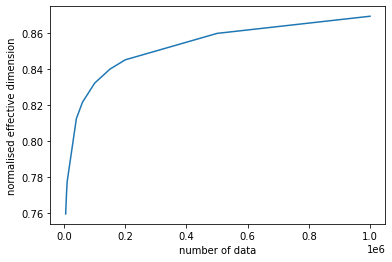

In [31]:
print("effdim: ", global_eff_dim)
# plot the normalised effective dimension for the model
plt.plot(n, np.array(global_eff_dim)/d)
plt.xlabel('number of data')
plt.ylabel('normalised effective dimension')
plt.show()

## 4. Circuit QNN + User-Defined Inputs and Params

In [14]:
params = np.random.uniform(2, 2.5, size=(num_thetas, qnn.num_weights))
x = np.random.normal(0, 3, size=(num_inputs, qnn.num_inputs))

global_ed = EffectiveDimension(qnn=qnn,
                               thetas=params,
                               inputs=x)

effdim:  [4.558452076088769, 4.631301528059119, 4.666488667269054, 4.875161851825501, 4.929696235660089, 4.993272553108722, 5.0396971438485805, 5.070553638579655, 5.1582808211035855, 5.215255475166902]


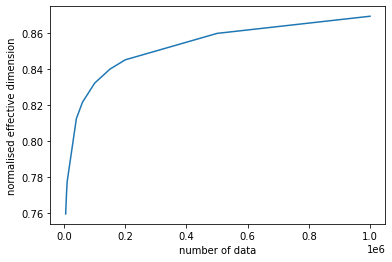

In [15]:
global_eff_dim, time = global_ed.eff_dim(n = n)
d = global_ed.d
print("effdim: ", global_eff_dim)
# plot the normalised effective dimension for the model
plt.plot(n, np.array(global_eff_dim)/d)
plt.xlabel('number of data')
plt.ylabel('normalised effective dimension')
plt.show()

In [26]:
# construct QNN
qnn3 = CircuitQNN(
    qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    # interpret=parity,
    # output_shape=output_shape,
    sparse=False,
    quantum_instance=qi_sv
)

effdim:  [5.884699880758852, 5.889047342910681, 5.891526174597641, 5.907937803163807, 5.912387812985925, 5.917591146733739, 5.9213944061599495, 5.923922597788582, 5.931109009524316, 5.935774513294356]


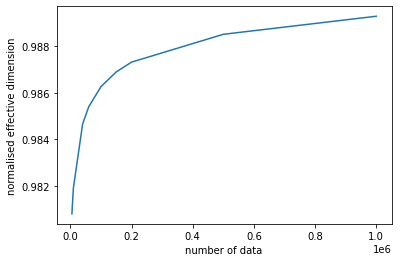

In [32]:
global_ed_3 = EffectiveDimension(qnn=qnn3,
                               thetas=params,
                               inputs=x)

global_eff_dim_3, time = global_ed_3.eff_dim(n = n)
d = global_ed.d
print("effdim: ", global_eff_dim_3)
# plot the normalised effective dimension for the model
plt.plot(n, np.array(global_eff_dim_3)/d)
plt.xlabel('number of data')
plt.ylabel('normalised effective dimension')
plt.show()

## B. Use with Opflow QNN

In [16]:
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient

In [17]:
# specify the observable
observable = PauliSumOp.from_list([("Z" * num_qubits, 1)])
print(observable)
# define two layer QNN
qnn2 = TwoLayerQNN(
    num_qubits, feature_map=feature_map, ansatz=ansatz, observable=observable, quantum_instance=qi_sv
)

1.0 * ZZZ


In [18]:
global_ed2 = EffectiveDimension(qnn=qnn2,
                               thetas=params,
                               inputs=x)

effdim:  [4.558452076088769, 4.631301528059119, 4.666488667269054, 4.875161851825502, 4.9296962356600895, 4.993272553108722, 5.039697143848581, 5.070553638579655, 5.1582808211035855, 5.215255475166902]


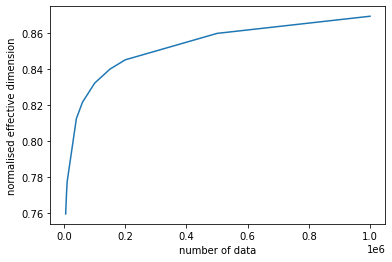

In [19]:
global_eff_dim2, time = global_ed2.eff_dim(n = n)
d = global_ed2.d
print("effdim: ", global_eff_dim2)
# plot the normalised effective dimension for the model
plt.plot(n, np.array(global_eff_dim2)/d)
plt.xlabel('number of data')
plt.ylabel('normalised effective dimension')
plt.show()

## Local Effective Dimension

In [20]:
local_ed = LocalEffectiveDimension(qnn=qnn2,
                               thetas=params,
                               inputs=x)

NOOO, ERROR!!!


AttributeError: 'LocalEffectiveDimension' object has no attribute 'params'

In [21]:
local_ed = LocalEffectiveDimension(qnn=qnn2,
                               thetas=params[0],
                               inputs=x)

(1, 6)


In [22]:
local_ed = LocalEffectiveDimension(qnn=qnn2,
                               thetas=[params[0]],
                               inputs=x)

(1, 6)


In [24]:
local_eff_dim, time = local_ed.eff_dim(n = n)
d = local_ed.d

In [25]:
print(local_eff_dim)

[4.731033385170862, 4.787521798802278, 4.815491989087426, 4.989158412581431, 5.0363593141057565, 5.092084552809736, 5.133161792005917, 5.160610124929054, 5.239127870706966, 5.290388644027565]
